In [529]:
x = np.arange(6)

In [530]:
x

array([0, 1, 2, 3, 4, 5])

In [501]:
import numpy as np
class Expert():

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivativa(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tan_hiperbolica(self, x):
        #from https://alexander-wong.com/post/neural-networks-and-deep-learning-week3/
        return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

    def tan_hiperbolica_derivativa(self, x):
        #from https://alexander-wong.com/post/neural-networks-and-deep-learning-week3/
        return 1 - self.tan_hiperbolica(x)**2
    
    def softmax(self,x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def softmax_derivativa(self,x):
        '''
        Derivativa funcao de softmax
        '''
        x = np.asarray(x)
        elem_matrix = []
        for elem in x:
            position_array = []
            for i in range(0,len(elem)):
                elem_i = []
                for j in range(0,len(elem)):
                    if i == j:
                        elem_i.append(elem[i] * (1-elem[i]))
                    else:
                        elem_i.append(elem[i] * elem[j])
                position_array.append(np.sum(elem_i))
            elem_matrix.append(position_array)
        return elem_matrix
    
    
    def __init__(self,ne,nh,ns,g_h,g_o):
        '''
        ne = numero de neuronios entradas
        nh = numero neuronios hidden layer
        ns = numero de neuronios saida
        
        As funcoes de ativacao sao denotadas por
        g_h = funcao de ativacao camada escondida
        g_o = funcao de ativacao camada de saida
        
        e podem receber as seguintes entradas
        'sigmoid', 'tan_h', 'softmax'
        '''
        self.W1=np.random.uniform(size=(ne,nh))
        self.b1=np.random.uniform(size=(1,nh))
        self.W2=np.random.uniform(size=(nh,ns))
        self.b2=np.random.uniform(size=(1,ns))
        self.ghidden = g_h
        self.gout = g_o
        
    def executa_funcao_ativacao(self, tipo, x, derivativa=False):
        if tipo == 'sigmoid':
            if derivativa:
                return self.sigmoid_derivativa(x)
            else:
                return self.sigmoid(x)
        elif tipo == 'tan_h':
            if derivativa:
                return self.tan_hiperbolica_derivativa(x)
            else:
                return self.tan_hiperbolica(x)
        elif tipo == 'softmax':
            if derivativa:
                return self.softmax_derivativa(x)
            else:
                return self.softmax(x)
        elif tipo == 'linear'
            if derivatica:
                return np.ones(x.shape)
            else
                return x
    
    def train(self, max_epoch, alpha, X, y, plot=False):
        eqm = []
        for epoch in range(1,max_epoch):
            #Forward Propogation
            #hidden
            a1=np.dot(X,self.W1) + self.b1
            z1 = self.executa_funcao_ativacao(self.ghidden, a1)
            #saida
            a2=np.dot(z1,self.W2)+ self.b2
            z2 = self.executa_funcao_ativacao(self.gout, a2)
            #Calculo do erro e eqm
            erro_epoca = y-z2
            _eqm =  1.0/len(y) * np.sum(np.sum(np.square(erro_epoca), axis=0))
            eqm.append(_eqm)
            
            #Backpropagation
            delta_output = self.executa_funcao_ativacao(self.gout, z2, derivativa=True)
            d_z2 = erro_epoca * delta_output
                
            erro_hidden = d_z2.dot(self.W2.T) * (1/len(X))
                        
            delta_hidden = self.executa_funcao_ativacao(self.ghidden,z1,derivativa=True)
            d_z1 = erro_hidden * delta_hidden * (1/len(X))
            
            #Atualiza pesos
            self.W2 += z1.T.dot(d_z2) * alpha
            self.b2 += np.sum(d_z2, axis=0,keepdims=True) * alpha
            self.W1 += X.T.dot(d_z1) * alpha
            self.b1 += np.sum(d_z1, axis=0,keepdims=True) * alpha

        if plot:       
            import matplotlib.pyplot as plt
            plt.plot(eqm)
            plt.show()
            

        

In [502]:
#Validando com o XOR

In [507]:
#Input array
X=np.array([[1,0,1,0],[1,0,1,1],[0,1,0,1]])

#Output
y=np.array([[1],[1],[0]])

In [526]:
#Variable initialization
max_epocas=1000
alpha=0.1 #Setting learning rate
ne = X.shape[1] #numero de features no dataset
nh = 6 #numero neuronios hidden
ns = 1 #numero neuronios saida

In [527]:
ep =Expert(ne,nh,ns,g_h='softmax',g_o='sigmoid')

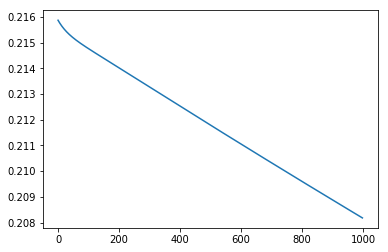

In [528]:
ep.train(max_epocas, alpha, X, y, plot=True)